
# 보일러 효율 영향 인자 분석 — **v5-fast**


In [7]:

#효율 상위 30%를 고효율 상태로 정의.
FILE_PATTERN = './*.csv'
EFF_COL = '열 손실법 효율'
TOP_PERCENT = 30
Q_FOR_POSITIVE = 100 - TOP_PERCENT

#모델 훈련 가속을 위한 설정
FAST_SUBSAMPLE_FRAC = 0.35
FAST_SEED = 42
USE_RANDOM_SEARCH = True
RANDOM_SEARCH_ITER = 12
CV_SPLITS = 3
SKIP_PERM_IMPORTANCE = True

TEST_SIZE = 0.2
RANDOM_STATE = 42
HEAVY_MISSING_THRESHOLD = 0.80
MAX_ITER = 2000

#의미 없는 컬럼값 미리 제거
EXCLUDE_COLUMNS = [
    '생성일','급수펌프','배기 재 순환 온도','운전시간','확률 업데이트',
    '효율(순간)','효율(입출력법-스팀)','정상 운전','송풍기 고장 확률',
    'AIR 댐퍼 고장 확률','GAS 앰퍼 고장 확률','확률 업데이트 시간', '입출력법 효율'
]

import os, glob, warnings, platform
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from matplotlib import rc

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    font_name = 'AppleGothic'
else:
    font_name = 'NanumGothic'
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False
print("[INFO] Matplotlib font set to:", font_name)


[INFO] Matplotlib font set to: Malgun Gothic


In [8]:

# csv 파일 로드
#결과 출력을 위한 한글 폰트 설정
def read_csv_fallback(path):
    for enc in ('utf-8', 'cp949', 'euc-kr'):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError("All tried encodings failed", b'', 0, 1, "unsupported")

files = sorted(glob.glob(FILE_PATTERN))
if not files:
    raise FileNotFoundError(f'No CSV files found for pattern: {FILE_PATTERN}')

dfs, failed = [], []
for f in files:
    try:
        df_tmp = read_csv_fallback(f)
        df_tmp['__source_file__'] = os.path.basename(f)
        dfs.append(df_tmp)
    except Exception as e:
        print(f"[WARN] Failed to read {f}: {e}")
        failed.append((f, str(e)))
if not dfs:
    raise RuntimeError('No CSVs could be read.')

df_raw = pd.concat(dfs, ignore_index=True)
print('Loaded rows:', len(df_raw), 'from files:', len(dfs))
if failed:
    print('Failed files (up to 3 shown):', failed[:3])
df_raw.head(3)


Loaded rows: 458364 from files: 14


,생성일,부하율,설정 압력,보일러 압력,송풍기 인버터 출력,송풍기 입력,급수 펌프,급수펌프 입력,가스 댐퍼,가스 댐퍼 입력,Air 댐퍼,Air 댐퍼 입력,재순환 댐퍼,재순환 외기 댐퍼,재순환 댐퍼 입력,재순환 외기 댐퍼 입력,급수 수위,보일러 온도,배기가스온도1,배기가스온도2,배기가스온도3,배기 재 순환 온도,에코 온도1,에코 온도2,버너온도,배기가스 NOx,배기가스 O2,재순환 O2,재순환 NOx,급수량(적산유량),급수량(순간유량),연료량(적산유량),연료량(순간유량),효율(순간),소비전류,진동센서1,진동센서2,운전시간,정상 운전 확률,송풍기 고장 확률,AIR 댐퍼 고장 확률,GAS 앰퍼 고장 확률,확률 업데이트 시간,순간 스팀량,입출력법 효율,열 손실법 효율,효율(입출력법-스팀),__source_file__
0,50.0,5.6,5.5,69.0,59.4,75.0,0,25.0,25.8,30.0,30.5,30.0,35.0,30.9,35.5,70.0,164.6,191.0,87.1,53.2,-,41.0,58.1,-,6.0,5.2,0,0,19498.99,2.78,1413104.0,84.1,198.09,32.22,0,0,14946:56,1.08,7.62,91.1,0.2,2025-06-10 09:28:01,2.0,134.23,94.69,142.81,NaN,28_2025-08-26.csv
1,50.0,5.6,5.5,69.0,59.4,0.0,0,25.0,25.8,30.0,30.4,30.0,35.0,30.6,35.7,100.0,164.6,190.9,87.1,53.2,-,41.0,58.1,-,7.0,5.3,0,0,19498.99,3.30,1413104.0,83.7,236.74,33.07,0,0,14946:56,1.08,7.62,91.1,0.2,2025-06-10 09:28:01,2.2,160.09,94.67,157.85,NaN,28_2025-08-26.csv
2,50.0,5.6,5.5,69.0,59.5,0.0,0,25.0,25.8,30.0,30.4,30.0,35.0,30.8,35.5,100.0,164.6,190.9,87.1,53.2,-,41.0,58.0,-,6.0,5.3,0,0,19498.99,3.21,1413104.0,83.5,230.49,32.84,0,0,14946:56,1.08,7.62,91.1,0.2,2025-06-10 09:28:01,2.3,156.10,94.67,165.42,NaN,28_2025-08-26.csv


Target rule: Top 30% (>= 154.7300)
Drop columns: ['진동센서2', '배기가스온도3', '에코 온도2'] 
[FAST] Subsampled to 160427 rows
Final X shape: (160427, 33) / y shape: (160427,)


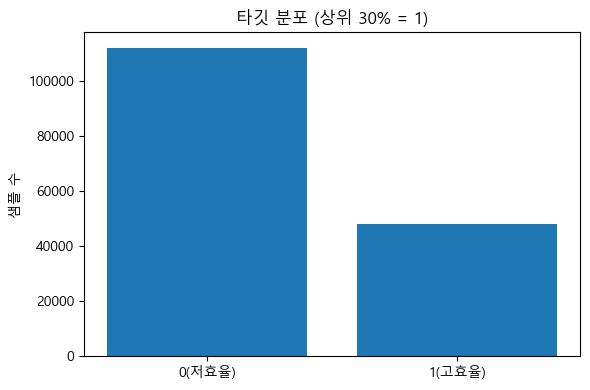

In [9]:

# 전처리 + 추가 작업
df = df_raw.copy()
df.columns = [str(c).strip() for c in df.columns]
df = df.replace({'-': np.nan, '–': np.nan, '—': np.nan, '': np.nan, ' ': np.nan})

def to_numeric_safe(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '', regex=False), errors='coerce')

df_num = df.copy()
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df_num[col] = to_numeric_safe(df[col])
        except Exception:
            pass

if EFF_COL not in df_num.columns or df_num[EFF_COL].dropna().shape[0] == 0:
    raise KeyError(f"'{EFF_COL}' 컬럼을 찾지 못했거나 값이 없습니다.")
eff_series = df_num[EFF_COL].astype(float)
thr = np.nanpercentile(eff_series, Q_FOR_POSITIVE)
df_num['target'] = (eff_series >= thr).astype('Int64')
print(f"Target rule: Top {TOP_PERCENT}% (>= {thr:.4f})")

drop_cols = ['__source_file__', EFF_COL] + [c for c in EXCLUDE_COLUMNS if c in df_num.columns]
X = df_num.drop(columns=drop_cols + ['target'], errors='ignore')
y = df_num['target']

numeric_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
X = X[numeric_cols].replace([np.inf, -np.inf], np.nan)

null_rate = X.isna().mean()
all_nan_cols = null_rate[null_rate == 1.0].index.tolist()
heavy_missing_cols = null_rate[null_rate >= HEAVY_MISSING_THRESHOLD].index.tolist()
to_drop = list(set(all_nan_cols + heavy_missing_cols))
if to_drop:
    print("Drop columns:", to_drop[:10], "..." if len(to_drop) > 10 else "")
    X = X.drop(columns=to_drop)

valid = y.notna()
X, y = X.loc[valid].reset_index(drop=True), y.loc[valid].astype(int).reset_index(drop=True)

if FAST_SUBSAMPLE_FRAC and 0 < FAST_SUBSAMPLE_FRAC < 1.0:
    idx = X.sample(frac=FAST_SUBSAMPLE_FRAC, random_state=FAST_SEED).index
    X, y = X.loc[idx].reset_index(drop=True), y.loc[idx].reset_index(drop=True)
    print(f"[FAST] Subsampled to {len(X)} rows")

print('Final X shape:', X.shape, '/ y shape:', y.shape)

counts = y.value_counts()
plt.figure(figsize=(6,4))
plt.bar(['0(저효율)','1(고효율)'], [counts.get(0,0), counts.get(1,0)])
plt.title('타깃 분포 (상위 30% = 1)')
plt.ylabel('샘플 수')
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'logit__tol': 0.0005, 'logit__solver': 'lbfgs', 'logit__random_state': 42, 'logit__penalty': 'l2', 'logit__max_iter': 2000, 'logit__class_weight': None, 'logit__C': np.float64(0.26366508987303583)}
=== Test Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     22434
           1       0.89      0.96      0.92      9652

    accuracy                           0.95     32086
   macro avg       0.94      0.96      0.95     32086
weighted avg       0.96      0.95      0.95     32086

=== Test Confusion Matrix ===
[[21290  1144]
 [  371  9281]]


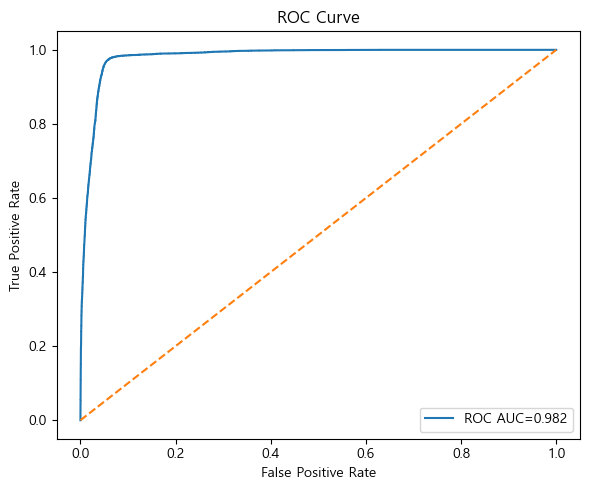

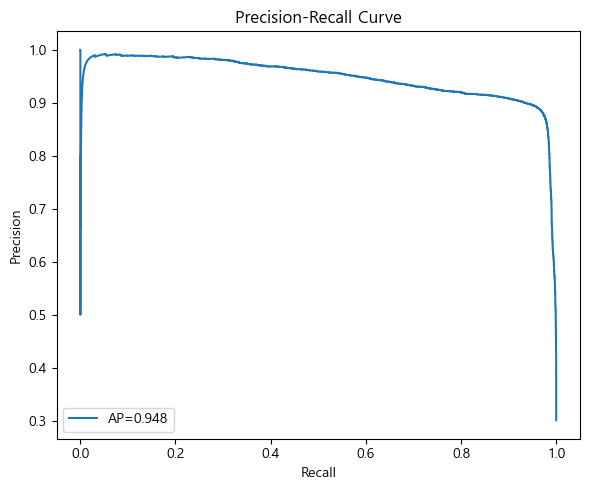

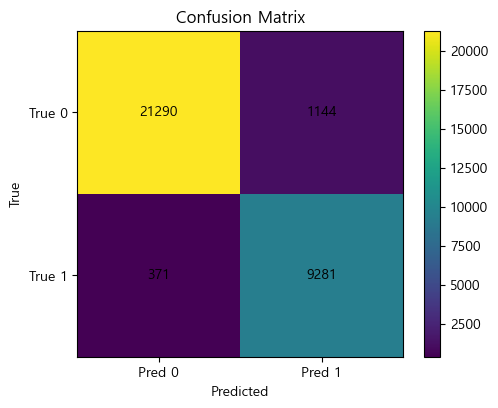

In [10]:

# 모델 학습
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logit", LogisticRegression(max_iter=MAX_ITER, solver='lbfgs'))
])

if USE_RANDOM_SEARCH:
    param_dist = {
        "logit__penalty": ['l2'],
        "logit__C": np.logspace(-2, 1, 20),
        "logit__class_weight": [None, "balanced"],
        "logit__solver": ['lbfgs', 'saga'],
        "logit__max_iter": [MAX_ITER],
        "logit__random_state": [RANDOM_STATE],
        "logit__tol": [1e-4, 5e-4, 1e-3],
    }
    cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=RANDOM_SEARCH_ITER,
        scoring='f1',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        refit=True,
        random_state=RANDOM_STATE
    )
    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_
    print("Best params:", search.best_params_)
else:
    best_pipe = pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

print("=== Test Classification Report ===")
print(classification_report(y_test, y_pred))
print("=== Test Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

#시각화
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# Confusion Matrix heatmap
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0,1]
plt.xticks(tick_marks, ['Pred 0','Pred 1'])
plt.yticks(tick_marks, ['True 0','True 1'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


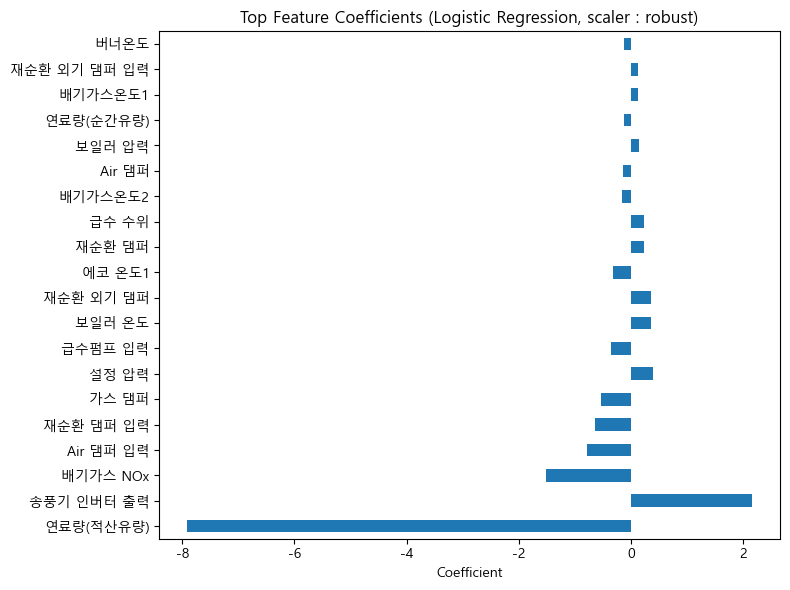

In [11]:

# === 기여도: 표준화 계수 Top 20 (빠름) ===
logit = best_pipe.named_steps["logit"]
coef_series = pd.Series(logit.coef_[0], index=X.columns, name="coef (scaled space)")
coef_abs = coef_series.abs().sort_values(ascending=False)

top_k = min(20, len(coef_series))
plt.figure(figsize=(8,6))
coef_series.loc[coef_abs.head(top_k).index].plot(kind="barh")
plt.title("Top Feature Coefficients (Logistic Regression, scaler : robust)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
